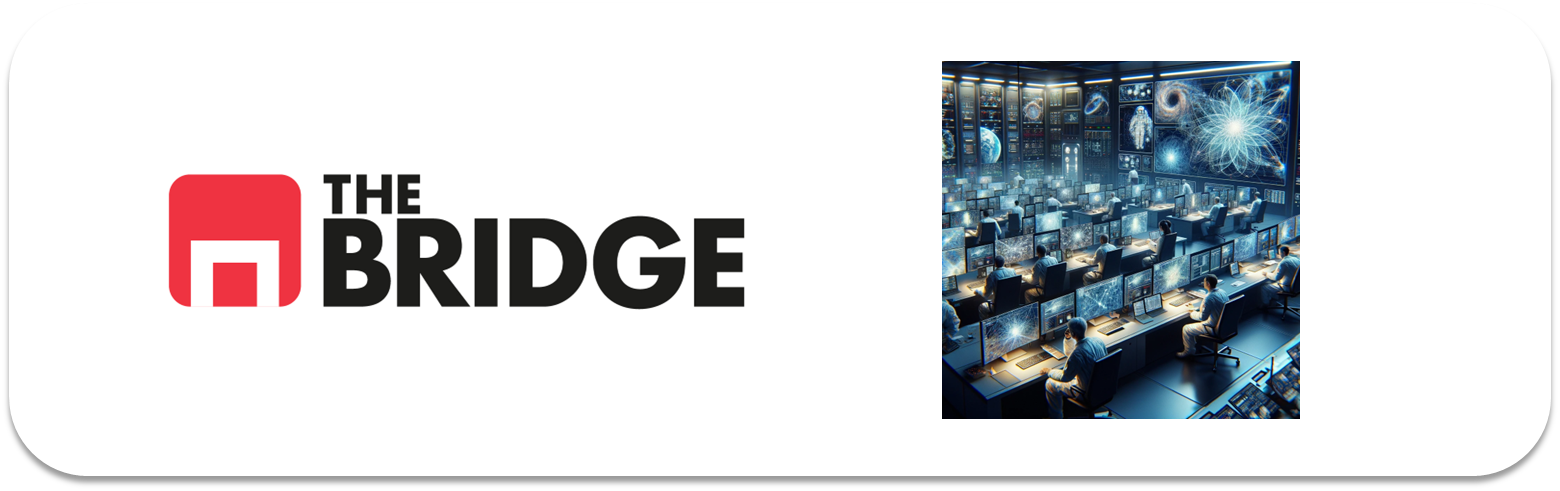

## PRACTICA OBLIGATORIA: **Transfer Learning y Fine Tuning con CNN**

* La práctica obligatoria de esta unidad consiste en un repetir el ejercicio de construcción de un modelo de clasificación de paisajes pero usando un modelo preentrenado. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from skimage.io import imread
from sklearn.utils import shuffle
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import keras
import cv2

### Objetivo del ejercicio

Comparar una red convolucional hecha ad-hoc frente a los modelos preentrenados y ajustados con fine tuning y transfer learning. Para ello emplea el dataset de paisajes del conjunto de ejercicios de la unidad anterior.


### Se pide

1. Preparar los datos del modelo y las funciones de visualización, copia para ello todo lo que necesites de las soluciones del ejercicio de clasificación de paisajes de la unidad anterior.

2. Escoger entre uno de los modelos VGG-19, InceptionV3 y MobileNetV2 (todos en https://keras.io/api/applications/) (Se aconseja este último si no tenemos un ordenador muy potente). Si no te haces con estos puedes recurrir a la ResNetV50.

4. Hacer un transfer-learning con una cabeza de como mucho 2 capas densas ocultas y una de salida. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

5. Hacer un fine-tuning con la misma cabeza diseñada en el punto anterior. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

6. Comparar los resultados con los obtenidos con la red convolucional del ejercicio mencionado.

EXTRA:
- Repetir el transfer learning empleando aumentado de imágenes.



In [2]:
ROOT_PATH = './data/'
TRAIN_PATH = ROOT_PATH + "seg_train/seg_train"
TEST_PATH = ROOT_PATH + "seg_test/seg_test"

In [3]:
def read_data(directorio, reshape_dim = (32,32)):
    X = [] 
    y = []
    for folder in os.listdir(directorio):
        print(folder)
        if os.path.isdir('/'.join([directorio, folder])):
            for file in os.listdir('/'.join([directorio, folder])):

                image = imread('/'.join([directorio, folder, file]))
                image = cv2.resize(image, reshape_dim) # Redimensionamos las imágenes a 32x32

                X.append(image)
                y.append(folder)

    return np.array(X),np.array(y)

In [4]:
X_train,y_train = read_data(TRAIN_PATH, reshape_dim=(64,64))
X_test, y_test = read_data(TEST_PATH, reshape_dim=(64,64)) # Nota: podríamos dejar la creación de X_test para el final antes de usarlo y así ahorra memoria mientras no tengamos que emplearlo

buildings
forest
glacier
mountain
sea
street
buildings
forest
glacier
mountain
sea
street


In [5]:
print('X train shape: ', X_train.shape)
print('Y train shape: ', y_train.shape)

X train shape:  (14034, 64, 64, 3)
Y train shape:  (14034,)


In [6]:
print('X train shape: ', X_test.shape)
print('Y train shape: ', y_test.shape)

X train shape:  (3000, 64, 64, 3)
Y train shape:  (3000,)


In [7]:
def show_images_batch(paisajes, names = [], n_cols = 5, size_scale = 2):
    n_rows = ((len(paisajes) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * size_scale, n_rows * 1.1*size_scale))
    for index, paisaje in enumerate(paisajes):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(paisaje, cmap = "Greys")
        plt.axis("off")
        if len(names):
            plt.title(names[index])

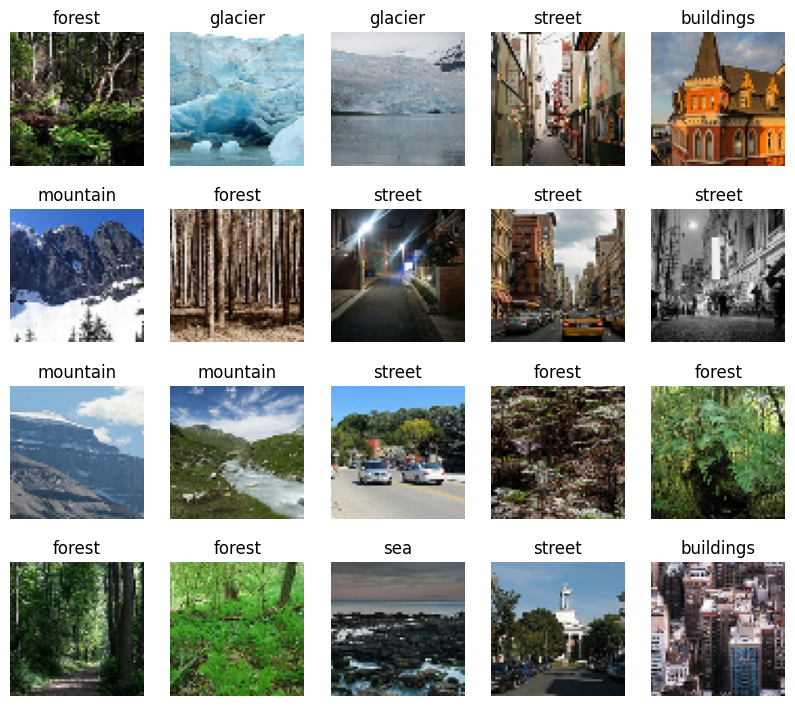

In [8]:
indices = np.random.randint(0,len(X_train),20)
show_images_batch(X_train[indices], names = y_train[indices], n_cols = 5)

MiniEDA y normalización

In [9]:
targets = pd.Series(y_train)
targets.value_counts(True)

mountain     0.178994
glacier      0.171298
street       0.169731
sea          0.162035
forest       0.161821
buildings    0.156121
Name: proportion, dtype: float64

In [10]:
#Limpio la memoria porque me está dando problemas varios (por eso también hice reshape a 64 porque a 224 imposible)
import gc
gc.collect()

38447

In [11]:
X_train = X_train/255
X_test = X_test/255

MobileNetV2

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder

# Reescalar las imágenes al tamaño esperado por MobileNetV2

X_train_resized = np.array([cv2.resize(img, (224, 224)) for img in X_train])
X_test_resized = np.array([cv2.resize(img, (224, 224)) for img in X_test])

# Codificar etiquetas en números
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

# Carga del modelo base
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False  # Transfer learning (sin fine-tuning por ahora)

# Construimos la cabeza personalizada (máx 2 densas + salida)
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(len(encoder.classes_), activation='softmax')
])

# Compilamos
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [13]:
print(X_train.shape, y_train_encoded.shape)
print(np.isnan(X_train).sum())  # Verifica si hay NaNs
print(np.unique(y_train_encoded))  # Asegura que hay varias clases

(14034, 64, 64, 3) (14034,)
0
[0 1 2 3 4 5]


Entrenamiento con validación

In [14]:
gc.collect()

0

In [15]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(
    X_train_resized, y_train_encoded,
    epochs=30,
    batch_size=8,
    validation_split=0.2,
    callbacks=[early_stop]
)

Epoch 1/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 290s 202ms/step - accuracy: 0.7136 - loss: 0.7494 - val_accuracy: 0.1329 - val_loss: 8.7764
Epoch 2/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 302s 215ms/step - accuracy: 0.8818 - loss: 0.3344 - val_accuracy: 0.1247 - val_loss: 9.2917
Epoch 3/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 192s 137ms/step - accuracy: 0.8926 - loss: 0.2998 - val_accuracy: 0.1340 - val_loss: 9.9733
Epoch 4/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 197s 140ms/step - accuracy: 0.9103 - loss: 0.2582 - val_accuracy: 0.1375 - val_loss: 10.1099
Epoch 5/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 912s 650ms/step - accuracy: 0.9183 - loss: 0.2366 - val_accuracy: 0.1336 - val_loss: 10.8817
Epoch 6/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 200s 142ms/step - accuracy: 0.9205 - loss: 0.2150 - val_accuracy: 0.1372 - val_loss: 13.3030


Esto tiene un overfitting bastante alto. Entrena casi perfecto pero se cae en el test. Vamos a probar un fine tuning

In [16]:
#Desbloqueo capas del modelo base
# Hacemos que el modelo base sea entrenable
base_model.trainable = True

# Bloqueamos las primeras capas para evitar cambiar filtros muy generales
for layer in base_model.layers[:80]:
    layer.trainable = False

In [ ]:
#Recompilo con tasa de aprendizaje más baja y uso un adam

model.compile(
    optimizer=Adam(learning_rate=1e-5),  # learning rate bajo para no romper pesos previos
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [18]:
#Reentreno

gc.collect()  # Limpieza de memoria

early_stop = EarlyStopping(patience=5, restore_best_weights=True)

history_ft = model.fit(
    X_train_resized, y_train_encoded,
    epochs=20,
    batch_size=8,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/20
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 337s 231ms/step - accuracy: 0.7261 - loss: 0.7201 - val_accuracy: 0.1400 - val_loss: 8.2520
Epoch 2/20
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 324s 231ms/step - accuracy: 0.8350 - loss: 0.4529 - val_accuracy: 0.1407 - val_loss: 7.7978
Epoch 3/20
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 326s 232ms/step - accuracy: 0.8633 - loss: 0.3774 - val_accuracy: 0.1454 - val_loss: 8.3277
Epoch 4/20
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 325s 232ms/step - accuracy: 0.8725 - loss: 0.3432 - val_accuracy: 0.1421 - val_loss: 8.7115
Epoch 5/20
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 318s 227ms/step - accuracy: 0.8911 - loss: 0.3005 - val_accuracy: 0.1457 - val_loss: 9.5513
Epoch 6/20
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 334s 238ms/step - accuracy: 0.9057 - loss: 0.2689 - val_accuracy: 0.1468 - val_loss: 9.6868
Epoch 7/20
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 309s 220ms/step - accuracy: 0.9127 - loss: 0.2454 - val_accuracy: 0.1471 - val_loss: 10.5380


El modelo sigue sin generalizae bien.

In [19]:
# Evaluación en test
loss, acc = model.evaluate(X_test_resized, y_test_encoded)
print(f"📉 Pérdida (fine-tuning) en test: {loss:.4f}")
print(f"🎯 Precisión (fine-tuning) en test: {acc:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 35s 366ms/step - accuracy: 0.9076 - loss: 0.3750
📉 Pérdida (fine-tuning) en test: 1.7524
🎯 Precisión (fine-tuning) en test: 0.7493


Después del fine tuning tiene una precisión de 74.93% en test que está bastante mejor

94/94 ━━━━━━━━━━━━━━━━━━━━ 34s 349ms/step


c:\Users\sheir\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


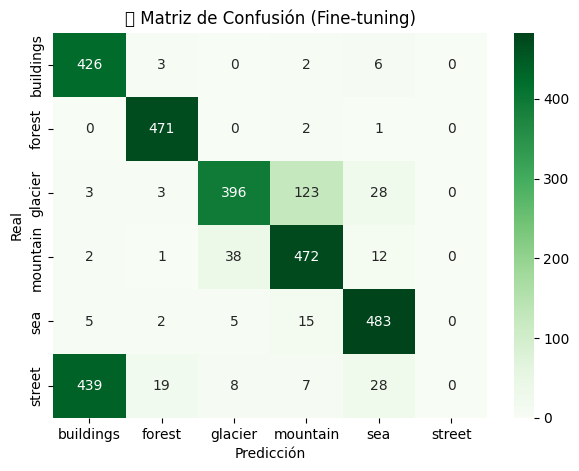

              precision    recall  f1-score   support

   buildings       0.49      0.97      0.65       437
      forest       0.94      0.99      0.97       474
     glacier       0.89      0.72      0.79       553
    mountain       0.76      0.90      0.82       525
         sea       0.87      0.95      0.90       510
      street       0.00      0.00      0.00       501

    accuracy                           0.75      3000
   macro avg       0.66      0.76      0.69      3000
weighted avg       0.66      0.75      0.69      3000



c:\Users\sheir\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sheir\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sheir\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [ ]:
# Predicciones
y_pred_ft_probs = model.predict(X_test_resized)
y_pred_ft = y_pred_ft_probs.argmax(axis=1)

# Matriz
cm = confusion_matrix(y_test_encoded, y_pred_ft)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("📊 Matriz de Confusión (Fine-tuning)")
plt.show()

# Reporte
print(classification_report(y_test_encoded, y_pred_ft, target_names=encoder.classes_))

| Clase      | Precisión | Exhaustividad (Recall) | F1-score | Soporte | Observación                               |
|------------|-----------|------------------------|----------|---------|-------------------------------------------|
| buildings  | 0.49      | 0.97                   | 0.65     | 437     | Clasifica casi todo como "buildings"      |
| forest     | 0.94      | 0.99                   | 0.97     | 474     | ¡Excelente rendimiento!                  |
| glacier    | 0.89      | 0.72                   | 0.79     | 553     | Precisión alta, pero con errores frecuentes  |
| mountain   | 0.76      | 0.90                   | 0.82     | 525     | Bastante sólido                          |
| sea        | 0.87      | 0.95                   | 0.90     | 510     | Muy buen rendimiento                    |
| street     | 0.00      | 0.00                   | 0.00     | 501     | Confunde completamente con "buildings"   |

| **Accuracy global** |      |                        | **0.7493** | 3000    |                                             |

Entre street y buildings hay un a confusión sistemática. 

Comparativa con el modelo de los ejercicios

| Clase      | F1-score (CNN Clase) | F1-score (MobileNetV2 Fine-tuning) | Mejor modelo |
|------------|----------------------|------------------------------------|--------------|
| buildings  | 0.64                 | 0.65                               | Similar       |
| forest     | 0.86                 | **0.97**                           | MobileNetV2   |
| glacier    | 0.70                 | **0.79**                           | MobileNetV2   |
| mountain   | 0.66                 | **0.82**                           | MobileNetV2   |
| sea        | 0.55                 | **0.90**                           | MobileNetV2   |
| street     | **0.73**             | 0.00                               | CNN Clase     |

| **Accuracy total** | 0.70                 | **0.75**                           | MobileNetV2   |
| **Macro avg F1**   | 0.69                 | **0.69**                           | Empate        |

- MobileNetV2 mejora de forma significativa en forest, sea, mountain, y glacier, con f1-scores bastante más altos.  
- El modelo CNN de clase logra una clasificación decente para street, donde MobileNetV2 falla por completo.  
- En accuracy total, el modelo con fine-tuning supera a la CNN por 5 puntos porcentuales, pero la CNN tiene un rendimiento más equilibrado entre clases urbanas.


| Modelo                       | Accuracy en Test | Pérdida en Test | Observación                              |
|-----------------------------|------------------|------------------|------------------------------------------|
| CNN (Ejercicio de Clase)    | 0.6703           | 0.8569           | Rendimiento equilibrado, buen baseline   |
| MobileNetV2 (Transfer)      | ~0.13 (val)      | >10 (val_loss)   | No generalizó, sobreajuste brutal        |
| MobileNetV2 (Fine-tuning)   | **0.7493**       | **1.7524**       | Mejor precisión, pero aún pierde en street |

La comparativa revela que, si bien los modelos preentrenados pueden ofrecer mejoras notables, su éxito depende de una correcta adaptación (fine-tuning) y de que las clases estén representadas y diferenciadas visualmente en el conjunto de datos. En este caso, la CNN clásica demostró mayor equilibrio entre categorías urbanas y naturales, mientras que MobileNetV2 con fine-tuning dominó en entornos naturales.
En contextos reales, una solución híbrida o un refinamiento adicional por clase podría maximizar el rendimiento global.

